<a href="https://colab.research.google.com/github/SrinidDev/AUTOML/blob/main/RFR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn  as sns
import scipy.stats
from scipy import stats
from scipy.stats import chi2
from io import StringIO
import time
#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_squared_log_error,r2_score,median_absolute_error,explained_variance_score,max_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
pd.set_option("display.max_columns",100)
pd.set_option("display.max_rows",1000)
import statsmodels.api as sm
from scipy.stats import *
from sklearn.preprocessing import *
from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from pytz import timezone
import warnings
warnings.simplefilter("ignore")
from datetime import datetime,timedelta


In [2]:
path="/content/IndianHouses.csv"

In [3]:
df=pd.read_csv(path)
df.head(3)

,Area,BHK,Bathroom,Furnishing,Locality,Parking,Price,Status,Transaction,Type,Per_Sqft
0,800.0,3,2.0,Semi-Furnished,Rohini Sector 25,1.0,6500000,Ready_to_move,New_Property,Builder_Floor,NaN
1,750.0,2,2.0,Semi-Furnished,"J R Designers Floors, Rohini Sector 24",1.0,5000000,Ready_to_move,New_Property,Apartment,6667.0
2,950.0,2,2.0,Furnished,"Citizen Apartment, Rohini Sector 13",1.0,15500000,Ready_to_move,Resale,Apartment,6667.0


In [4]:
def variabletype(dataframe,vtype=None):
        df = dataframe
        columns = dataframe.columns
        num_col_list=['int','float']
        numerical_columns = list(df.select_dtypes(include=num_col_list).columns)
        #numerical_columns = [var for var in dataframe if dataframe[var].dtypes != 'O']
        categorical_columns = [var for var in dataframe if dataframe[var].dtypes == 'O']
        binary_columns = [var for var in dataframe if len(dataframe[var].dropna().value_counts()) <= 2]
        null_columns = dataframe.columns[dataframe.isnull().any()]

        cols_list_df=pd.DataFrame(
        {
            'Numerical Columns':pd.Series(numerical_columns),
            'Categorical Columns':pd.Series(categorical_columns),
            'Binary_Columns':pd.Series(binary_columns),
            'Null Columns':pd.Series(null_columns)
        })
        blankIndex=[''] * len(cols_list_df)
        cols_list_df.index=blankIndex
        if(vtype in cols_list_df.columns):
            return (pd.DataFrame({vtype:cols_list_df[vtype]}).dropna())
        else:
            cols_list_df.fillna('',inplace=True)
            return cols_list_df

In [5]:
var=['Numerical Columns','Categorical Columns','Binary_Columns','Null Columns']
res=variabletype(df)
res

,Numerical Columns,Categorical Columns,Binary_Columns,Null Columns
,Area,Furnishing,Status,Bathroom
,BHK,Locality,Transaction,Furnishing
,Bathroom,Status,Type,Parking
,Parking,Transaction,,Type
,Price,Type,,Per_Sqft
,Per_Sqft,,,


In [6]:
def overview(df):
        try:
            num_col_list=['int','float']
            numerical_columns = list(df.select_dtypes(include=num_col_list).columns)
            #numerical_columns = [var for var in df if df[var].dtypes != 'O']
            categorical_columns = [var for var in df if df[var].dtypes == 'O']
            binary_columns = [var for var in df if len(df[var].dropna().value_counts()) <= 2]
            newdf=df.select_dtypes(include=np.number)
            negative_columns=(newdf<0).sum().sum()
            infinite_columns=np.isinf(newdf).sum().sum()
            null_columns = df.columns[df.isnull().any()]

            col = ['Dataset statistics','count']
            dataset_overview = pd.DataFrame(columns = col)
            dataset_overview.loc[0] = ['Number of Observations', df.shape[0]]
            dataset_overview.loc[1] = ['Number of Variables',df.shape[1]]
            dataset_overview.loc[2] = ['Categorical Variables',len(categorical_columns)]
            dataset_overview.loc[3] = ['Numerical Variables',len(numerical_columns)]
            dataset_overview.loc[4] = ['Binary Variables',len(binary_columns)]
            dataset_overview.loc[5] = ['Missing value Variables',len(df.columns[df.isnull().any()])]
            dataset_overview.loc[6] = ['Missing Cells',df.isnull().sum().sum()]
            dataset_overview.loc[7] = ['Missing Cells (%)', np.round(df.isnull().sum().sum()/(df.shape[0] * df.shape[1]),4) * 100]
            dataset_overview.loc[8] = ['Negative Cells',negative_columns]
            dataset_overview.loc[9] = ['Negative Cells (%)', np.round(negative_columns/(df.shape[0] * df.shape[1]),4) * 100]
            dataset_overview.loc[10] = ['Infinite Value Cells',infinite_columns]
            dataset_overview.loc[11] = ['Infinite Value Cells (%)', np.round(infinite_columns/(df.shape[0] * df.shape[1]),4) * 100]

            blankIndex=[''] * len(dataset_overview)
            dataset_overview.index=blankIndex
            return dataset_overview
        except Exception as e:
            return e

In [7]:
overview(df)

,Dataset statistics,count
,Number of Observations,1259.00
,Number of Variables,11.00
,Categorical Variables,5.00
,Numerical Variables,6.00
,Binary Variables,3.00
,Missing value Variables,5.00
,Missing Cells,286.00
,Missing Cells (%),2.07
,Negative Cells,0.00
,Negative Cells (%),0.00


In [8]:
def categorical_variables(df,variable=None):
        try:
            i = 0
            #categorical_columns = [var for var in df if df[var].dtypes == 'O']
            col = ['Categorical Variables','Observation','Distinct Count', 'Missing Values','Missing Values (%)']
            catg_variables = pd.DataFrame(columns = col)
            if(variable==None):
                    categorical_columns = [var for var in df if df[var].dtypes == 'O']
            else:
                    categorical_columns=[variable]
            for var in categorical_columns:
                    catg_variables.loc[i] = [var,
                                        df[var].count(),
                                        df[var].nunique(),
                                        df[var].isnull().sum(),
                                        np.round(df[var].isnull().sum()/df.shape[0],4)*100]



                    i+=1



            return catg_variables
        except Exception as e:
            return e

categorical_variables(df)

,Categorical Variables,Observation,Distinct Count,Missing Values,Missing Values (%)
0,Furnishing,1254,3,5,0.4
1,Locality,1259,365,0,0.0
2,Status,1259,2,0,0.0
3,Transaction,1259,2,0,0.0
4,Type,1254,2,5,0.4


In [9]:
def univ_freq_table(df, variables):
    univ_result = pd.DataFrame()
    for var in variables:
        univ = pd.DataFrame()

        univ_freq = df[var].value_counts().rename_axis('Variable').reset_index(name='Frequency')
        univ_per = (df[var].value_counts(normalize = True) * 100).rename_axis('Variable').reset_index(name='Percent (%)')

        univ = pd.merge(univ_freq, univ_per, on='Variable', how = 'inner')

        univ['Category'] = var

        univ['Variable'] =univ['Variable'].astype(str)

        univ_result = univ_result.append(univ)
        cols = univ_result.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        finaldf=univ_result[cols]
    return finaldf

In [10]:
var=['Status','Furnishing','Transaction','Type']
univ_freq_table(df,var)

,Category,Variable,Frequency,Percent (%)
0,Status,Ready_to_move,1184,94.042891
1,Status,Almost_ready,75,5.957109
0,Furnishing,Semi-Furnished,708,56.459330
1,Furnishing,Unfurnished,363,28.947368
2,Furnishing,Furnished,183,14.593301
0,Transaction,Resale,781,62.033360
1,Transaction,New_Property,478,37.966640
0,Type,Builder_Floor,661,52.711324
1,Type,Apartment,593,47.288676


In [4]:
print('Old Data Shape',df.shape)
df_v1=df.drop(['Locality'],axis=1)
print('After removeal of locality',df_v1.shape)


Old Data Shape (1259, 11)
After removeal of locality (1259, 10)


In [14]:
df_v1.isna().sum()

Area             0
BHK              0
Bathroom         2
Furnishing       5
Parking         33
Price            0
Status           0
Transaction      0
Type             5
Per_Sqft       241
dtype: int64

In [5]:
def numericalmissingimputer(df2,variable,method,val=None):


    df2[variable]=df2[variable].astype(float)
    if(method=='mean'):
            imp_val=df2[variable].mean()
            df2[variable]=df2[variable].fillna(imp_val)
            out_df=pd.DataFrame({
            "Variable":variable,
            "Method":method,
            "Imputed Value":pd.Series(imp_val)
            })
            out_df.index.name = 'Variable'
            blankIndex=[''] * len(out_df)
            out_df.index=blankIndex

    elif(method=='median'):
            imp_val=df2[variable].median()

            df2[variable] = df2[variable].fillna(imp_val)
            out_df=pd.DataFrame({
            "Variable":variable,
            "Method":method,
            "Imputed Value":pd.Series(imp_val)
            })
            out_df.index.name = 'Variable'
            blankIndex=[''] * len(out_df)
            out_df.index=blankIndex

    elif(method=='mode'):
           imp_val=[]
           for var in variable:
                impval=df2[var].mode()[0]

                df2[var] = df2[var].fillna(impval)
                #print(var)
                imp_val.append(impval)
           out_df=pd.DataFrame({
            "Variable":variable,
            "Method":method,
            "Imputed Value":pd.Series(imp_val)
            })





    elif(method=='specificvalue'):

            imp_val=val

            df2[variable]=df2[variable].fillna(lambda x:imp_val,inplace =True)
            out_df=pd.DataFrame({
            "Variable":variable,
            "Method":method,

            "Imputed Value":pd.Series(imp_val)
            })
            blankIndex=[''] * len(out_df)
            out_df.index=blankIndex




    return out_df


print('Mean of Parking & Per_sqft before imputation',df_v1['Parking'].mean(),df_v1['Per_Sqft'].mean(),df_v1['Bathroom'].mode())

var=['Parking','Per_Sqft']
var2=['Bathroom']
resdf=numericalmissingimputer(df_v1,var,'mean')
resdf=numericalmissingimputer(df_v1,var2,'mode')
print('Mean of Parking & Per_sqft after imputation',df_v1['Parking'].mean(),df_v1['Per_Sqft'].mean(),df_v1['Bathroom'].mode())
resdf

Mean of Parking & Per_sqft before imputation 1.935562805872757 15690.136542239685 0    2.0
Name: Bathroom, dtype: float64
Mean of Parking & Per_sqft after imputation 1.9355628058727568 15690.136542239687 0    2.0
Name: Bathroom, dtype: float64


,Variable,Method,Imputed Value
0,Bathroom,mode,2.0


In [16]:
df_v1.isna().sum()

Area           0
BHK            0
Bathroom       0
Furnishing     5
Parking        0
Price          0
Status         0
Transaction    0
Type           5
Per_Sqft       0
dtype: int64

In [17]:
df_v1.head(3)

,Area,BHK,Bathroom,Furnishing,Parking,Price,Status,Transaction,Type,Per_Sqft
0,800.0,3,2.0,Semi-Furnished,1.0,6500000,Ready_to_move,New_Property,Builder_Floor,15690.136542
1,750.0,2,2.0,Semi-Furnished,1.0,5000000,Ready_to_move,New_Property,Apartment,6667.000000
2,950.0,2,2.0,Furnished,1.0,15500000,Ready_to_move,Resale,Apartment,6667.000000


In [6]:
def categoricalimputer(df2,variable,method,val=None):


    if(method=='most_frequent'):
            imp_val=df2[variable].mode().iloc[0]
            df2[variable]=df2[variable].fillna(imp_val)

    elif(method=='specificvalue'):
            #print(variable)
            imp_val=val
            df2[variable]=df2[variable].fillna(imp_val)
    out_df=pd.DataFrame({
    "Variable":variable,
    "Method":method,
    "Imputed Value":pd.Series(imp_val)
    })
    out_df.index.name = 'Variable'
    blankIndex=[''] * len(out_df)
    out_df.index=blankIndex
    return out_df

var3=['Furnishing','Type']
categoricalimputer(df_v1,var3,'most_frequent')

,Variable,Method,Imputed Value
,Furnishing,most_frequent,Semi-Furnished
,Type,most_frequent,Builder_Floor


In [7]:
#df2=df.copy()
def encodingfn(df2,variable,method=None,mappings=None):
    data_out,maps1,maps2=[],[],[]
    if(mappings==None and method=='DummyEncoding'):
            dum_df=pd.DataFrame()

            dum_df=pd.concat([pd.get_dummies(df2[col],drop_first=True,prefix=col) for col in variable], axis=1)

            for var in variable:
                spike_cols = [col for col in dum_df.columns if var in col]
                data_out.append(spike_cols)
            #print(data_out)
            mapdf=pd.DataFrame(
                      {'Variable': variable,
                        'Encoded Column':data_out

                    })
            map_df=mapdf.explode('Encoded Column')

            display(map_df)



    elif(mappings==None and method=='LabelEncoding'):

            encoder = LabelEncoder()
            dum_df=pd.DataFrame()

            for var in variable:
                dum_df[var+"_enc"] = encoder.fit_transform(df2[var])
                #dum_df['Original Data']=df2[var]

                data_out.append(var)
                maps1.append(encoder.classes_)
                maps2.append(encoder.transform(encoder.classes_))

            map_df=pd.DataFrame(
                      {'Variable': data_out,
                         'Category': maps1,
                         'Encoded Values': maps2
                        })
            display(map_df)

    elif(mappings!=None and method=='Mapping'):
        dum_df=pd.DataFrame()
        #for var in variable:
        for i in mappings:
                for j in mappings[i]:
                    #print(j)
                    dum_df[i+"_enc"]=df2[i].map(mappings[i]).fillna(np.nan)



        map_df=pd.concat({
        k: pd.DataFrame.from_dict(v, 'index',columns=['Encoded Values']) for k, v in mappings.items()
    },
    axis=0)
        display(map_df)

    return dum_df

In [23]:
df_v1.head(3)

,Area,BHK,Bathroom,Furnishing,Parking,Price,Status,Transaction,Type,Per_Sqft
0,800.0,3,2.0,Semi-Furnished,1.0,6500000,Ready_to_move,New_Property,Builder_Floor,15690.136542
1,750.0,2,2.0,Semi-Furnished,1.0,5000000,Ready_to_move,New_Property,Apartment,6667.000000
2,950.0,2,2.0,Furnished,1.0,15500000,Ready_to_move,Resale,Apartment,6667.000000


In [8]:

var=['Furnishing','Status','Transaction','Type']
result=encodingfn(df_v1,var,'LabelEncoding')
df_v1.head(3)

,Variable,Category,Encoded Values
0,Furnishing,"[Furnished, Semi-Furnished, Unfurnished]","[0, 1, 2]"
1,Status,"[Almost_ready, Ready_to_move]","[0, 1]"
2,Transaction,"[New_Property, Resale]","[0, 1]"
3,Type,"[Apartment, Builder_Floor]","[0, 1]"


,Area,BHK,Bathroom,Furnishing,Parking,Price,Status,Transaction,Type,Per_Sqft
0,800.0,3,2.0,Semi-Furnished,1.0,6500000,Ready_to_move,New_Property,Builder_Floor,15690.136542
1,750.0,2,2.0,Semi-Furnished,1.0,5000000,Ready_to_move,New_Property,Apartment,6667.000000
2,950.0,2,2.0,Furnished,1.0,15500000,Ready_to_move,Resale,Apartment,6667.000000


In [25]:
result.head(3)

,Furnishing_enc,Status_enc,Transaction_enc,Type_enc
0,1,1,0,1
1,1,1,0,0
2,0,1,1,0


In [9]:
df3=df_v1.copy()
df3.drop(var,inplace=True,axis=1)
df3.reset_index(drop=True, inplace=True)
result.reset_index(drop=True, inplace=True)
df4=pd.merge(df3, result, left_index=True, right_index=True)


df4.head(3)

,Area,BHK,Bathroom,Parking,Price,Per_Sqft,Furnishing_enc,Status_enc,Transaction_enc,Type_enc
0,800.0,3,2.0,1.0,6500000,15690.136542,1,1,0,1
1,750.0,2,2.0,1.0,5000000,6667.000000,1,1,0,0
2,950.0,2,2.0,1.0,15500000,6667.000000,0,1,1,0


In [10]:
x=df4.drop(['Price'],axis=1)
print('Independent Feat_Size',x.shape)
y=df4['Price']
print('Dep_var',y.shape)

Independent Feat_Size (1259, 9)
Dep_var (1259,)


In [11]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.3,random_state=50)
print('Train Size',x_train.shape)
print('Test Size',y_test.shape)

Train Size (881, 9)
Test Size (378,)


In [12]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(x_train, y_train)
pred=rf.predict(x_train)
print(pred.shape)
from pprint import pprint
# Look at parameters used by our current forest
print('Parameters currently in use:\n')
pprint(rf.get_params())


(881,)
Parameters currently in use:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 1000,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [34]:
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
val = 1000
nst="n_estimators"
rf = RandomForestRegressor(**{nst:val}, random_state = 42)
# Train the model on training data
rf.fit(x_train, y_train)
pred=rf.predict(x_train)
print(pred.shape)


(881,)


### Random Search Grid

In [39]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depths = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

max_leaf_nodes=[5,10]

max_samples=[0.3, 0.5, 0.8]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'max_leaf_nodes':max_leaf_nodes,
               'max_samples':max_samples,
               'bootstrap': bootstrap}


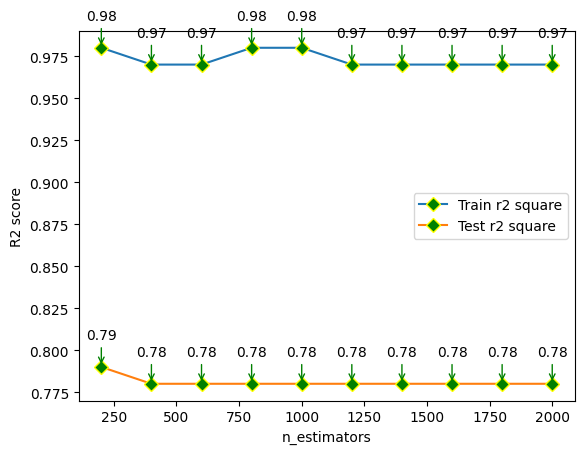

In [47]:

def score_plot(hp,x_train,x_test,y_train,y_test,model,hp_name):
      from matplotlib.legend_handler import HandlerLine2D
      train_results = []
      test_results = []


      for i in hp:

          dt =model(**{hp_name:i})
          dt.fit(x_train, y_train)
          #compute accuracy for train data
          y_pred = dt.predict(x_train)
          train_r2=np.round(r2_score(y_true=y_train, y_pred=y_pred),2)
          #append results of accuracy
          train_results.append(train_r2)

          #now again for test data
          y_pred = dt.predict(x_test)
          test_r2=np.round(r2_score(y_true=y_test, y_pred=y_pred),2)
          #append results of accuracy
          test_results.append(test_r2)





      line1, = plt.plot(hp, train_results, marker='D', mfc='green', mec='yellow',ms='7', label='Train r2 square')
      line2, = plt.plot(hp, test_results, marker='D', mfc='green', mec='yellow',ms='7', label= 'Test r2 square')

      for x,y,n, in zip(hp,train_results,test_results):

          label = "{:.2f}".format(y)

          plt.annotate(label, # this is the value which we want to label (text)
                      (x,y), # x and y is the points location where we have to label
                      textcoords="offset points",
                      xytext=(0,20), # this for the distance between the points
                      # and the text label
                      ha='center',
                      arrowprops=dict(arrowstyle="->", color='green'))

          label2 = "{:.2f}".format(n)

          plt.annotate(label2, # this is the value which we want to label (text)
                      (x,n), # x and y is the points location where we have to label
                      textcoords="offset points",
                      xytext=(0,20), # this for the distance between the points
                      # and the text label
                      ha='center',
                      arrowprops=dict(arrowstyle="->", color='green'))



      plt.legend(handler_map={line1: HandlerLine2D(numpoints=1)})

      plt.ylabel('R2 score')
      plt.xlabel(hp_name)


score_plot(n_estimators,x_train,x_test,y_train,y_test,RandomForestRegressor,'n_estimators')